<a href="https://colab.research.google.com/github/Ang3lino/mlnn/blob/master/projects/3adversarialFashion/P54_Adversarial_Fashion_DL_D2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crafting adversarial examples for the fashion MNIST dataset


## Students: Angel Lopez Manriquez

### Description
Adversarial examples are inputs formed by applying small perturbations to examples from a dataset in order to make a NN to produce incorrect answer with a high probability. Evaluating different strategies for designing adversarial perturbations is an important topic because it helps to unsderstand and limit the vulnerability of DNNs to attacks. Due to the relevance of this topic, different Python libraries have been introduced to study and evaluate adversarial perturbations .

### Objectives
The goal of this project is to implement one or more ap- proaches to create adversarial examples for the fashion MNIST dataset https://github.com/zalandoresearch/fashion-mnist.

The student should: 1) Decide on a class of DNNs to be used for the analysis. 2) Design the appropriate adversarial perturbation approach to fool the chosen DNN. 3) Create the adversarial examples. 

4) Evaluate the performance of the DNN on created examples. As in other projects, a report should describe the characteristics of the design, implementation, and results. A Jupyter notebook should include calls to the implemented function that illustrate the way it works.


### Content of the notebook
Visualization of the dataset, explanation and a review from it.

Definition of a convolutional neural network, which will be fooled by four adversarial methods.

The test of the model to be fooled.

The instantiation of four methods, fast gradient method, fast gradient method with target, Jacobian-baed Saliency Map Approach and DeepFool.



### Requirements
In order to run appropiately the notebook we need to install the Adversarial robustness toolbox https://github.com/IBM/adversarial-robustness-toolbox, a python library supporting developers and researchers in defending machine learning models against adversarial threats.

The installation is very straightforward, just execute: 

In [1]:
!pip install adversarial-robustness-toolbox


### Libraries
As usual, we import the libraries needed to run our notebook. To build the model we use Keras as well as preprocessing the y variable. We also import the Classes to be used to fool the model.

The notebook demonstrates a simple example of using ART with Keras. The example train a small model on the  dataset
and creates adversarial examples using the methods described above.

Here we use the ART classifier to train the model, it would also be possible to provide a pretrained model to the ART classifier.

The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import random
import keras
import time

from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential

from art.classifiers import KerasClassifier
from art.attacks import FastGradientMethod, SaliencyMapMethod, DeepFool
from art.utils import load_mnist


Using TensorFlow backend.


In [0]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

### Load the dataset

The following function will set our dataset, in fact we could try with the MNIST (the digits one) dataset just be setting db name as mnist. 

In this case we do not need to preprocess the data (thanks god), it is ready to use. We do not describe the dataset as well, since it is very known.

In [0]:
# Step 1: Load the MNIST dataset
def read_dataset(db_name='fashion', max_train_samples=6000, max_test_samples=1000):
  if db_name == 'mnist':
      (x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()  # Load from the art library       
      names = list(range(10))  # declare the names, in this case they correspond with the indexes
  else:
      (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()  # train samples: 60e3, train samples: 10e3

      # limit the samples to work with
      x_train, y_train = x_train[:max_train_samples], y_train[:max_train_samples]  
      x_test, y_test = x_train[:max_test_samples], y_train[:max_test_samples]

      # expand the dimensions, needed to fit the model and the methods to create adversarial examples
      x_train = np.expand_dims(x_train, axis=3)
      x_test = np.expand_dims(x_test, axis=3)

      # pass the variable to categorical, required for the neural network training
      y_train = to_categorical(y_train)
      y_test = to_categorical(y_test)

      # declare the names where each class belongs to
      names = [ 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', ]

      # normalize every cell of the image
      x_train = x_train.astype('float32') / 255.
      x_test = x_test.astype('float32') / 255.
  
  return (x_train, y_train), (x_test, y_test), names 


In [6]:
# fetch the variables
(x_train, y_train), (x_test, y_test), names = read_dataset(db_name='fashion', 
                                                           max_train_samples=6000, 
                                                           max_test_samples=1000)

# print the shapes, just to know we are good
print('x_train shape', x_train.shape, 'y_train shape', y_train.shape)
print('x_test shape', x_test.shape, 'y_test shape', y_test.shape)
print('class labels: ', names, 'Total: ', len(names))


x_train shape (6000, 28, 28, 1) y_train shape (6000, 10)
x_test shape (1000, 28, 28, 1) y_test shape (1000, 10)
class labels:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] Total:  10


In [0]:
# declare explitely the minimum and maximum pixel value, since we normalized the values are 0 and 1, respectively.
min_pixel_value = 0  
max_pixel_value = 1

### Create the model
Parameters to specify the maximum samples are set for computational cost purposes, of course, working with all the samples would improve our scores but that is not our goal.

In [8]:
model = Sequential()  # Instantiate the model
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])


### Create the ART classifier
It is very important to wrap out model instance with the KerasClassifier object, since it is required for the methods, otherwise we will raise an exception. Let the wrapper know the minimum and maximum value, we specify the for performances purposes (I think since they can be inferred).

In [0]:
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

### Train the model


In [78]:
# Step 3: Train the ART classifier
# batch_size = 64
batch_size = 128
classifier.fit(x_train, y_train, batch_size=batch_size, nb_epochs=3)

Epoch 1/3
47/46 [==============================] - 2s 45ms/step - loss: 0.7520 - acc: 0.7191
Epoch 2/3
47/46 [==============================] - 2s 46ms/step - loss: 0.7301 - acc: 0.7355
Epoch 3/3
47/46 [==============================] - 2s 46ms/step - loss: 0.7016 - acc: 0.7307


### Functions for plottings
We define helper functions just to plot the images and results computed in the following cells.

In [0]:
def plot_images(image, noise, noisy_image,
                name_source, name_target,
                score_source, score_source_org, score_target,
                smooth=True, cmap=None):
    """
    Plot the image, the noisy image and the noise.
    Also shows the class-names and scores.

    Note that the noise is amplified to use the full range of
    colours, otherwise if the noise is very low it would be
    hard to see.

    image: Original input image.
    noise: Noise that has been added to the image.
    noisy_image: Input image + noise.
    name_source: Name of the source-class.
    name_target: Name of the target-class.
    score_source: Score for the source-class.
    score_source_org: Original score for the source-class.
    score_target: Score for the target-class.
    """
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Plot the original image.
    # Note that the pixel-values are normalized to the [0.0, 1.0]
    # range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation, cmap=cmap)
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    # Plot the noisy image.
    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation, cmap=cmap)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    # Plot the noise.
    # The colours are amplified otherwise they would be hard to see.
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation, cmap=cmap)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
def plot_adversarial_comparisons(x_test, preds, x_test_adv, noisy_preds, 
                                 sample_count=5, cmap=None):
  indexes = list(range(len(x_test_adv)))
  for i in random.sample(indexes, sample_count):
      print(i)
      j = np.argmax(preds[i])
      shape = (x_test[0].shape[0], x_test[0].shape[1])  # needed to plot the images
  
      # images
      image = x_test[i].reshape(shape)  # original image
      noisy_image = x_test_adv[i].reshape(shape)  # image with noise
  
      # benign image
      target_cls = np.argmax(preds[i])  # index of the class where the benign instance i belongs to
      name_source = names[target_cls]  # predicted class name 
      score_source_org = preds[i][target_cls]  # the probability of the class 
  
      # image with noise
      name_target = names[np.argmax(noisy_preds[i])]  # fooled class name
      score_source = noisy_preds[i][target_cls]  # probability of the true class
  
      noise = image - noisy_image  # compute the augmented noise
      score_target = noisy_preds[i][np.argmax(noisy_preds[i])]  # probability to be the fooled image
  
      print('correct name: ', name_source)
      print('adversarial name: ', name_target)
  
      plot_images(image, noise, noisy_image,
                  name_source, name_target,
                  score_source, score_source_org, score_target, cmap=cmap)

## Model evaluation
Let us see how good accurate our model is.

In [56]:

# Step 5: Evaluate the ART classifier on benign test examples
preds = classifier.predict(x_test)  # obtain the predictions
accuracy = np.sum(np.argmax(preds, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)  # count the number of coincidences of the good predicted classes and the divide the sum by the length of the y_test
print('Accuracy on benign test examples: {}%'.format(accuracy * 100))


Accuracy on benign test examples: 75.2%


As you can see, the acurracy is quite good, of course it could be improved easy by modifying our model's architecture or use the entire dataset to train the model but again, that's not our goal, let us continue.

## Cheating the model
Finally, let us review ways to fool the trained model, we define the function test_attack to obtain the accuracy of the model as well as getting the adversarial examples with their probabilities.

In [0]:
def test_attack(classifier, attack, x_test, preds):
  '''
  Classifier: an instance of KerasClassifier
  Attack: An instance from art.attacks
  x_test: the input test values
  preds: Predictions obtained from the model m by the time we passed the x_test data
  '''
  start = time.time()  # current time
  x_test_adv = attack.generate(x=x_test)  # let us generate possible adversarial examples, it might take a while
  print(f'\n[+]Time required to generate adversarial: {time.time() - start} sec. \n\n')   # how much time we took?
  
  # Evaluate the ART classifier on adversarial test examples
  noisy_preds = classifier.predict(x_test_adv)  # obtain the predictions given the adversarial examples
  accuracy = np.sum(np.argmax(noisy_preds, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)  #  how many good results we had ?
  print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))  

  # Make comparison images from the parameters computed here
  plot_adversarial_comparisons(x_test, preds, x_test_adv, noisy_preds, sample_count=10, cmap='gray')  

  return x_test_adv, noisy_preds

## Fast gradient method
Literally, the fastest method by far, it did not take to much to create adversarial examples, however it is tricky to obtain an appropiately epsilon.


[+]Time required to generate adversarial: 3.122699737548828 sec. 


Accuracy on adversarial test examples: 22.5%
419
correct name:  Trouser
adversarial name:  T-shirt/top


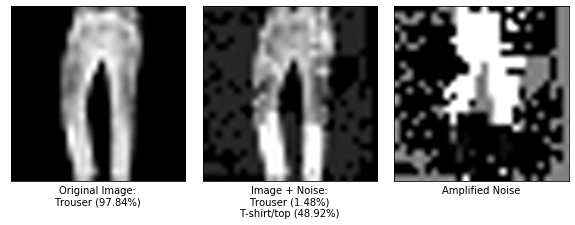

763
correct name:  Coat
adversarial name:  Pullover


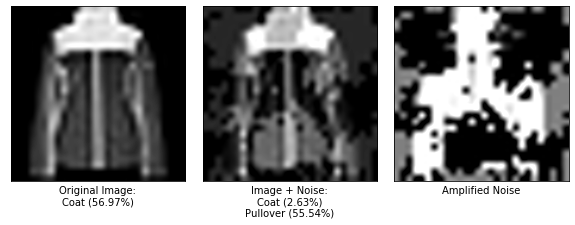

118
correct name:  Coat
adversarial name:  T-shirt/top


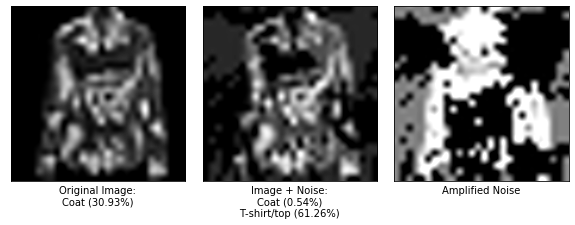

346
correct name:  Shirt
adversarial name:  Pullover


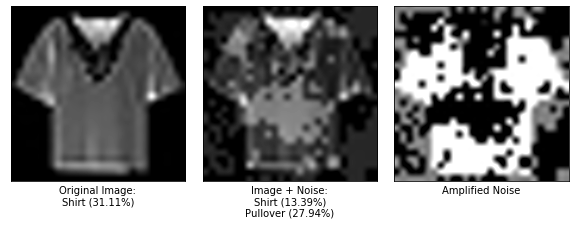

739
correct name:  Sneaker
adversarial name:  Sandal


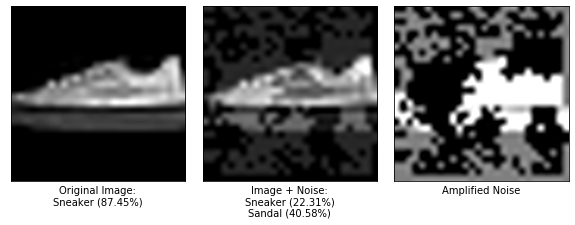

264
correct name:  Pullover
adversarial name:  Coat


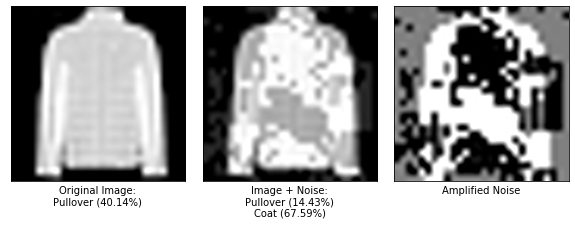

142
correct name:  Ankle boot
adversarial name:  Sneaker


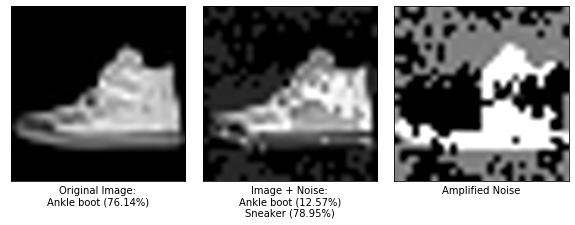

40
correct name:  Pullover
adversarial name:  Shirt


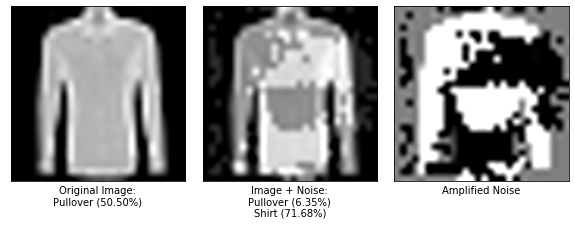

331
correct name:  T-shirt/top
adversarial name:  Shirt


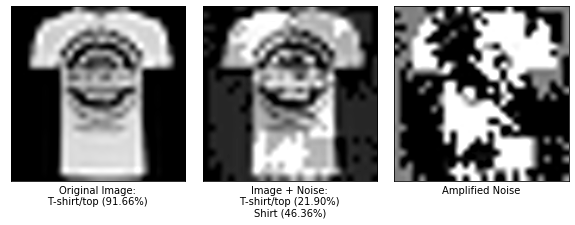

989
correct name:  Pullover
adversarial name:  Bag


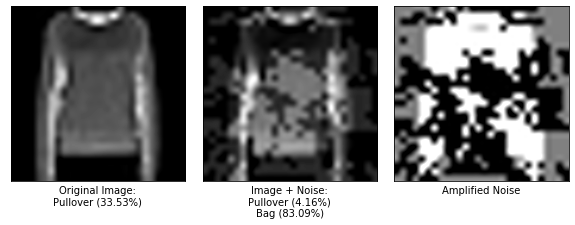

In [69]:
# Parameters
# classifier (Classifier) – A trained classifier.
# norm (int) – The norm of the adversarial perturbation. Possible values: np.inf, 1 or 2.
# eps (float) – Attack step size (input variation)
# eps_step (float) – Step size of input variation for minimal perturbation computation
# targeted (bool) – Indicates whether the attack is targeted (True) or untargeted (False)
# num_random_init (int) – Number of random initialisations within the epsilon ball. For random_init=0 starting at the original input.
# batch_size (int) – Size of the batch on which adversarial samples are generated.
# minimal (bool) – Indicates if computing the minimal perturbation (True). If True, also define eps_step for the step size and eps for the maximum perturbation.
eps = 0.15
attack = FastGradientMethod(classifier=classifier, eps=eps)
fgm_advs, fgm_preds = test_attack(classifier, attack, x_test, preds=preds)

## Fast gradient method with target
A variant from the fast gradient, as the name suggests, we need the true target in this methods. It is much faster than if we do not specify the targets.

We specify the labels in the instance method generate.


[+]Time required to generate adversarial: 1.8004179000854492 sec. 


Accuracy on adversarial test examples: 98.5%
734
correct name:  Sandal
adversarial name:  Sandal


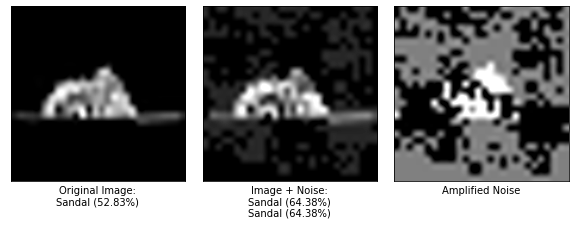

955
correct name:  Pullover
adversarial name:  Pullover


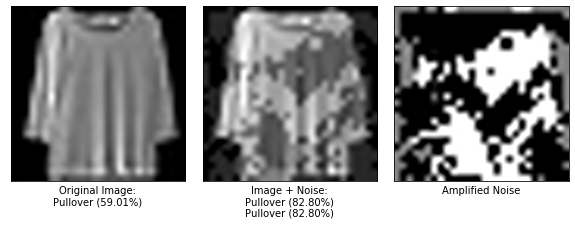

42
correct name:  Ankle boot
adversarial name:  Ankle boot


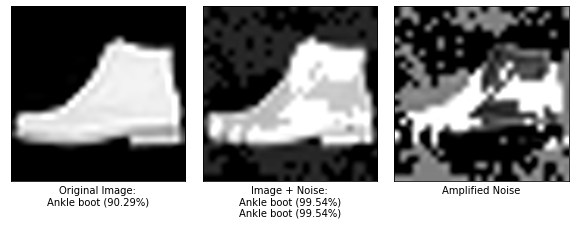

986
correct name:  Sneaker
adversarial name:  Sandal


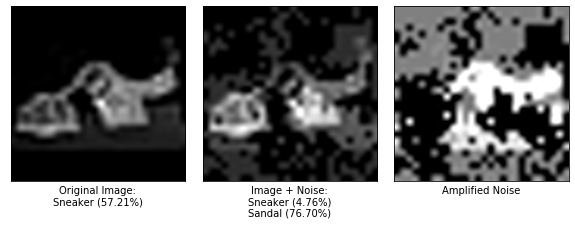

390
correct name:  Ankle boot
adversarial name:  Ankle boot


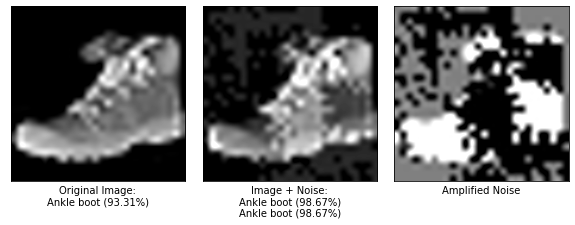

947
correct name:  Sandal
adversarial name:  Sandal


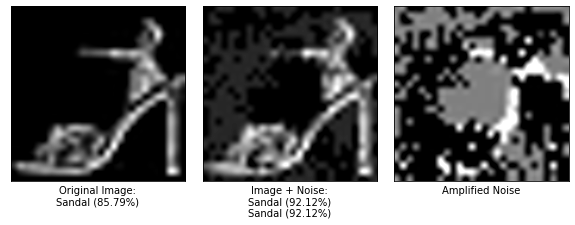

592
correct name:  T-shirt/top
adversarial name:  T-shirt/top


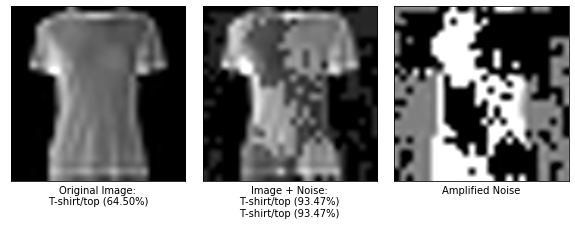

242
correct name:  Coat
adversarial name:  Coat


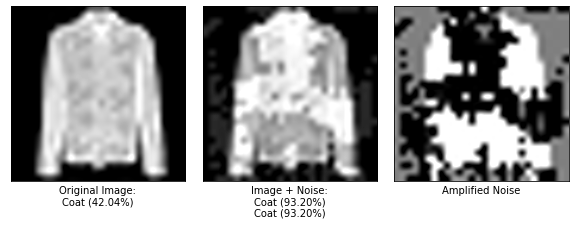

497
correct name:  Ankle boot
adversarial name:  Ankle boot


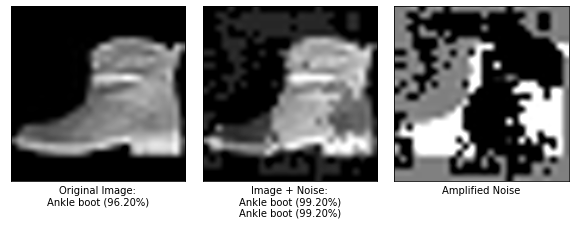

838
correct name:  Pullover
adversarial name:  Shirt


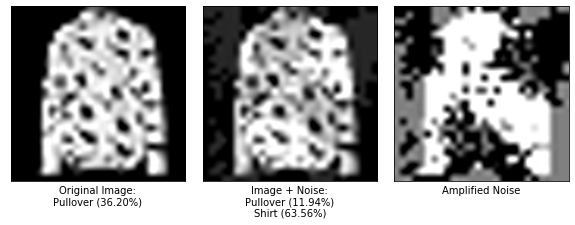

In [70]:

eps = 0.15
attack = FastGradientMethod(classifier=classifier, eps=eps, targeted=True)
start = time.time()
x_test_adv = attack.generate(x=x_test, y=y_test)  #  fit the generate with the labels here
print(f'\n[+]Time required to generate adversarial: {time.time() - start} sec. \n\n')   

# Step 7: Evaluate the ART classifier on adversarial test examples
noisy_preds = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(noisy_preds, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))
plot_adversarial_comparisons(x_test, preds, x_test_adv, noisy_preds, sample_count=10, cmap='gray')

## DeepFool
By far, the best model (at least in our test). It did not take too much to generate the adversarial examples. I say it is the best one since the examples does not look awful to the human eye and it fools the model.


[+]Time required to generate adversarial: 40.51535654067993 sec. 


Accuracy on adversarial test examples: 16.6%
97
correct name:  Trouser
adversarial name:  Dress


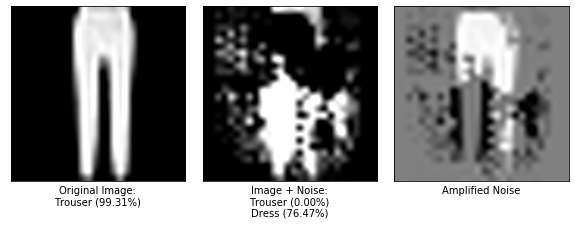

265
correct name:  Bag
adversarial name:  Pullover


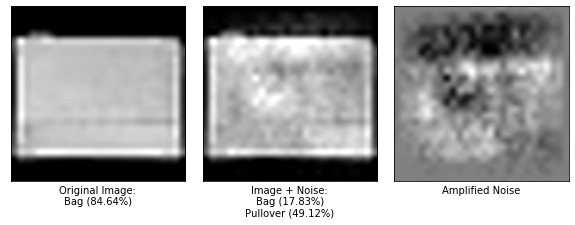

899
correct name:  Sandal
adversarial name:  Sandal


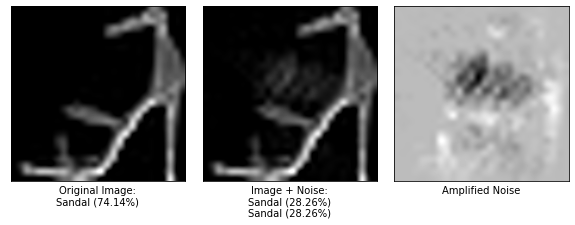

559
correct name:  Bag
adversarial name:  Sneaker


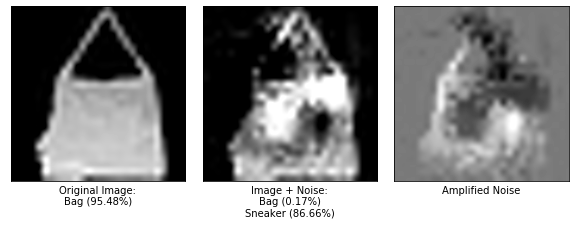

747
correct name:  Bag
adversarial name:  Sneaker


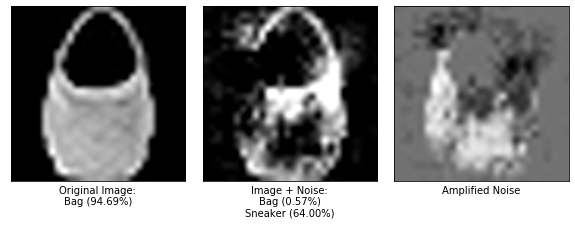

213
correct name:  Sandal
adversarial name:  Ankle boot


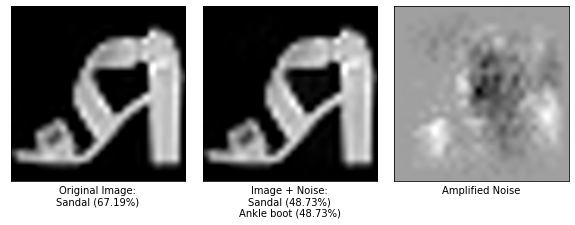

47
correct name:  Dress
adversarial name:  T-shirt/top


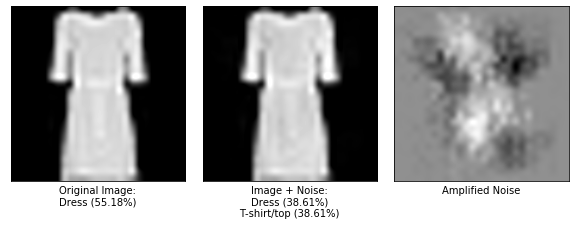

525
correct name:  Trouser
adversarial name:  Dress


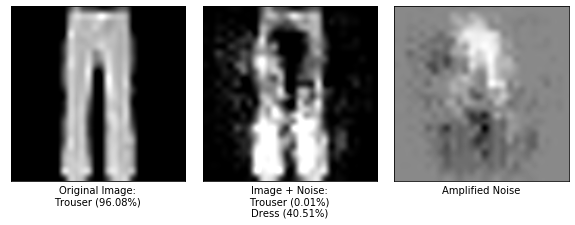

665
correct name:  T-shirt/top
adversarial name:  Shirt


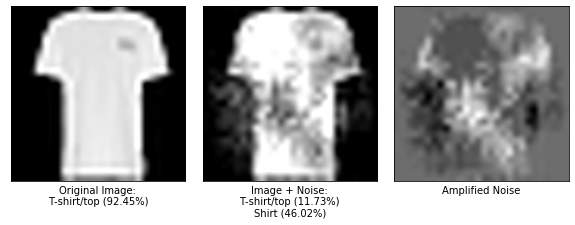

381
correct name:  Coat
adversarial name:  Pullover


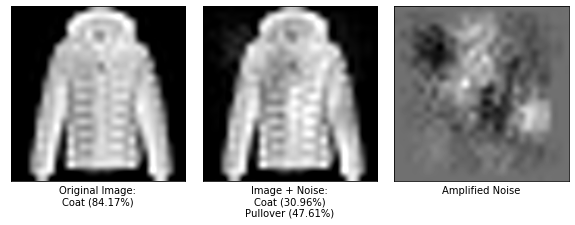

In [71]:
# def __init__(self, classifier, max_iter=100, epsilon=1e-6, nb_grads=10, batch_size=1):
"""
Create a DeepFool attack instance.
:param classifier: A trained classifier.
:type classifier: :class:`.Classifier`
:param max_iter: The maximum number of iterations.
:type max_iter: `int`
:param epsilon: Overshoot parameter.
:type epsilon: `float`
:param nb_grads: The number of class gradients (top nb_grads w.r.t. prediction) to compute. This way only the
                  most likely classes are considered, speeding up the computation.
:type nb_grads: `int`
:param batch_size: Batch size
:type batch_size: `int`
"""
eps = 0.1
attack = DeepFool(classifier=classifier, epsilon=eps)
df_advs, df_preds = test_attack(classifier, attack, x_test, preds=preds)

## The Jacobian-Based Saliency Map
The most computation time we took in generating adversarial examples was in this one, however the adversarial accuracy is the lowest one although some of the adversarial examples looks like if there were anything, but it does, we appreciate that in the probability displayed below. 

Even though nothing is shown sometimes, it is quite interesting how something could go unnoticed by the human eye.


[+]Time required to generate adversarial: 1030.8981444835663 sec. 


Accuracy on adversarial test examples: 5.5%
98
correct name:  Trouser
adversarial name:  Bag


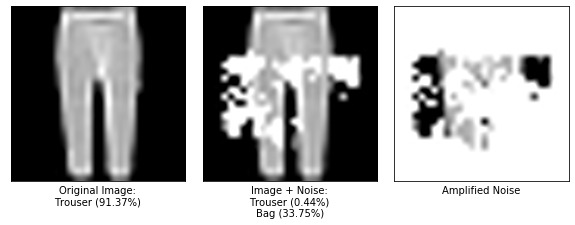

135
correct name:  Pullover
adversarial name:  Coat


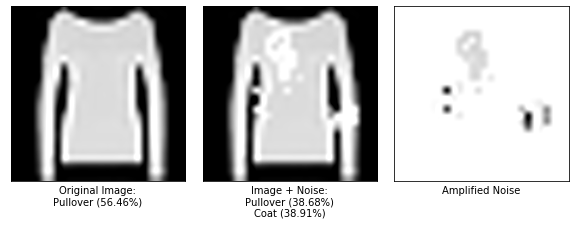

973
correct name:  Pullover
adversarial name:  Coat


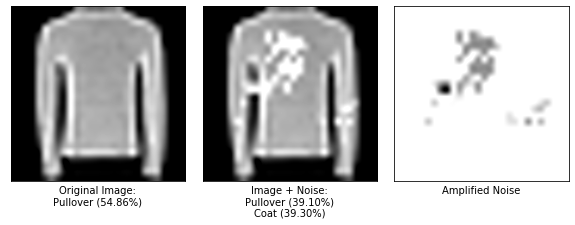

191
correct name:  T-shirt/top
adversarial name:  Pullover


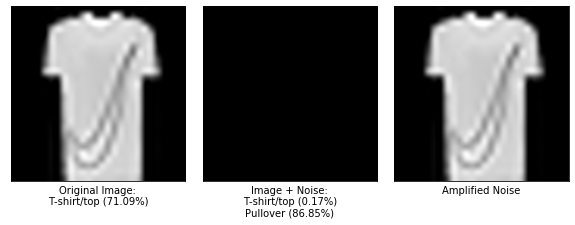

59
correct name:  Dress
adversarial name:  Shirt


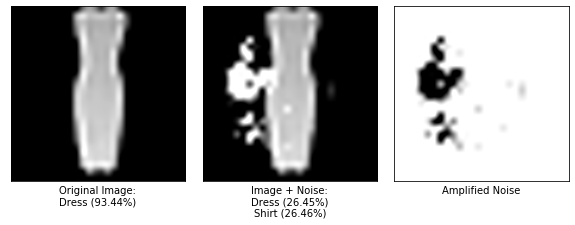

923
correct name:  Coat
adversarial name:  Pullover


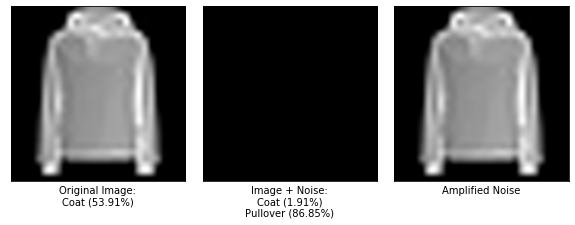

253
correct name:  Pullover
adversarial name:  Coat


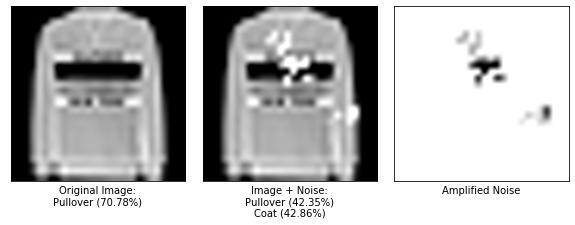

652
correct name:  Ankle boot
adversarial name:  Sandal


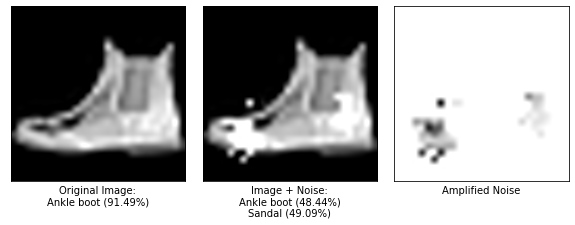

951
correct name:  Coat
adversarial name:  Pullover


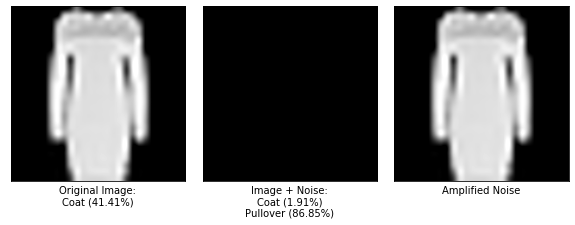

595
correct name:  T-shirt/top
adversarial name:  Pullover


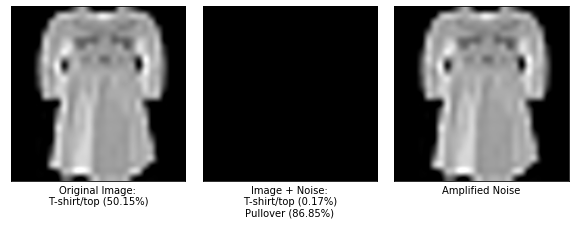

In [73]:
#         Create a SaliencyMapMethod instance.
#         :param classifier: A trained classifier.
#         :type classifier: :class:`.Classifier`
#         :param theta: Amount of Perturbation introduced to each modified feature per step (can be positive or negative).
#         :type theta: `float`
#         :param gamma: Maximum fraction of features being perturbed (between 0 and 1).
#         :type gamma: `float`
#         :param batch_size: Size of the batch on which adversarial samples are generated.
#         :type batch_size: `int`
attack = SaliencyMapMethod(classifier=classifier)
smm_advs, smm_preds = test_attack(classifier, attack, x_test, preds=preds) 


## Conclusion
We have shown how to find so-called Adversarial Examples that cause the Inception model to mis-classify images. Through a simple optimization process, we find noise that can be added to an input image so as to cause the Inception model to mis-classify the image, even though each pixel has only been changed slightly and the difference is imperceptible to humans.

Furthermore, the noise can be optimized so as to give a score (aka. probability or confidence) of nearly 100%. So not only is the input image mis-classified, but the neural network is apparently very confident that it has correctly classified the image.